## Set up

In [59]:
import pickle
from pathlib import Path

import keras as tfk
# import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.data import Dataset as tfds

sns.set_theme()

In [60]:
EXPERIMENT = "16-batchnorm"
EXPERIMENT_DIR = Path().absolute().parent / "results" / EXPERIMENT

MODEL_PATH = EXPERIMENT_DIR / "model.keras"
HISTORY_PATH = EXPERIMENT_DIR / "history.pkl"
TRAIN_PREDICTIONS_PATH = EXPERIMENT_DIR / "train_predictions.npy"
VAL_PREDICTIONS_PATH = EXPERIMENT_DIR / "val_predictions.npy"

### Load model

In [61]:
model: tfk.Model = tfk.saving.load_model(MODEL_PATH)
model

<Functional name=functional_3, built=True>

In [62]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_1 (Resizing)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobilenetV3large (Functional)   │ (None, 960)            │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 960)            │         3,840 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       246,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,792,986 (14.47 MB)

 Trainable params: 264,904 (1.01 MB)

 Non-trainable params: 2,998,272 (11.44 MB)

 Optimizer params: 529,810 (2.02 MB)

In [63]:
layer_weights: list[np.ndarray] = [
    model.layers[i].weights[0].numpy().flatten()
    for i in (-4, -3, -1)
]

<Axes: >

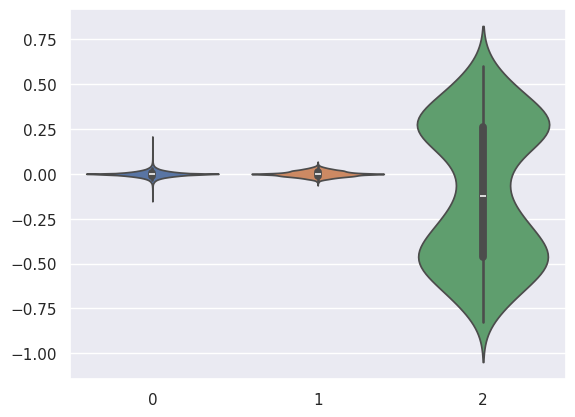

In [64]:
sns.violinplot(layer_weights)

### Load data

In [65]:
BATCH_SIZE = 128
AUGMENTED_DIR = Path().absolute().parent / "data" / "augmented"
TRAIN_TFDS_DIR = AUGMENTED_DIR / "train"
VAL_TFDS_DIR = AUGMENTED_DIR / "val"

train_dataset: tfds = tfds.load(str(TRAIN_TFDS_DIR)).batch(BATCH_SIZE)
val_dataset: tfds = tfds.load(str(VAL_TFDS_DIR)).batch(BATCH_SIZE)

train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 96, 96, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 8), dtype=tf.uint8, name=None))>

### Load predictions

In [66]:
y_train_pred = np.load(TRAIN_PREDICTIONS_PATH)
y_val_pred = np.load(VAL_PREDICTIONS_PATH)

In [67]:
y_train = np.concatenate(
    list(train_dataset.map(lambda _, y: y).as_numpy_iterator())
)
y_val = np.concatenate(
    list(val_dataset.map(lambda _, y: y).as_numpy_iterator())
)

print(y_train.shape)
print(y_val.shape)

(31688, 8)
(5592, 8)


2024-11-15 14:54:59.588915: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-15 14:54:59.718340: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [68]:
def decode(one_hot: np.ndarray) -> np.ndarray:
    return np.argmax(one_hot, axis=1)

In [69]:
label_train = decode(y_train)
label_val = decode(y_val)

label_train_pred = decode(y_train_pred)
label_val_pred = decode(y_val_pred)

In [70]:
outputs = {
    "train": (label_train, label_train_pred),
    "val": (label_val, label_val_pred),
}
outputs

{'train': (array([1, 0, 7, ..., 1, 0, 0]), array([1, 0, 7, ..., 1, 0, 0])),
 'val': (array([1, 4, 4, ..., 2, 6, 1]), array([1, 4, 4, ..., 2, 6, 1]))}

### Load history

In [71]:
with HISTORY_PATH.open("rb") as f:
    history: tfk.callbacks.History = pickle.load(f)
history_df = pd.DataFrame(history.history)
f1_df = history_df.filter(like="f1_score")
history_df = history_df[history_df.columns.difference(f1_df.columns)]
history_df

,accuracy,learning_rate,loss,precision,recall,val_accuracy,val_loss,val_precision,val_recall
0,0.544812,1.000000e-04,3.049357,0.778179,0.319395,0.826359,2.034877,0.955923,0.620529
1,0.784177,1.000000e-04,2.134502,0.889611,0.669118,0.881259,1.640538,0.945740,0.797926
2,0.847671,1.000000e-04,1.809812,0.915318,0.769187,0.906295,1.444641,0.948413,0.854793
3,0.882858,1.000000e-04,1.579453,0.930255,0.825833,0.920959,1.300153,0.954107,0.884835
4,0.902076,1.000000e-04,1.411967,0.940370,0.856981,0.929721,1.182017,0.953814,0.901109
...,...,...,...,...,...,...,...,...,...
65,0.994667,1.000000e-06,0.164547,0.996512,0.991669,0.968884,0.215602,0.973670,0.965486
66,0.995014,1.000000e-06,0.164535,0.996419,0.992300,0.968884,0.215622,0.973670,0.965486
67,0.994982,1.000000e-06,0.163523,0.996705,0.992647,0.968526,0.215565,0.973846,0.965486
68,0.995298,1.000000e-07,0.164229,0.996705,0.992868,0.968526,0.215563,0.973846,0.965486


## Analyse

### History

In [72]:
molten_history = history_df.reset_index().melt(id_vars="index")
molten_history["val"] = molten_history["variable"].str.contains("val_")
molten_history["variable"] = molten_history["variable"].str.replace("val_", "")
molten_history

,index,variable,value,val
0,0,accuracy,0.544812,False
1,1,accuracy,0.784177,False
2,2,accuracy,0.847671,False
3,3,accuracy,0.882858,False
4,4,accuracy,0.902076,False
...,...,...,...,...
625,65,recall,0.965486,True
626,66,recall,0.965486,True
627,67,recall,0.965486,True
628,68,recall,0.965486,True


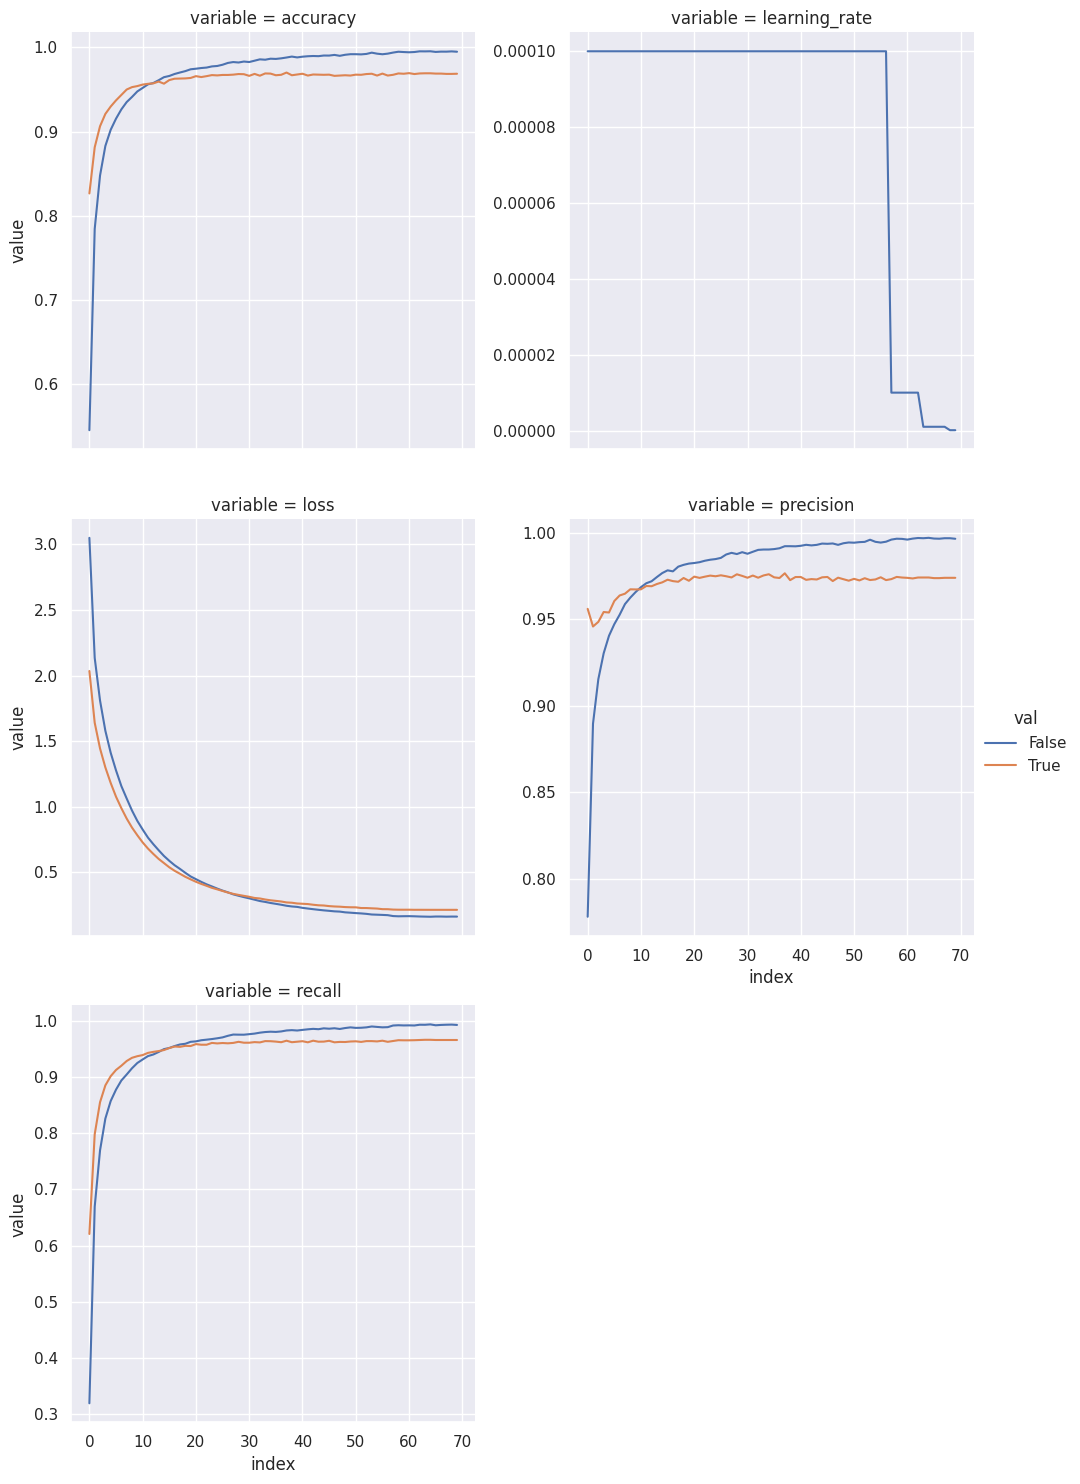

In [73]:
sns.relplot(
    molten_history,
    x="index",
    y="value",
    col="variable",
    col_wrap=2,
    hue="val",
    facet_kws={"sharey": False},
    kind="line",
)

### Classification metrics

In [74]:
for set_, (y_true, y_pred) in outputs.items():
    print(set_)
    print(classification_report(y_true, y_pred))
    print()

train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3962
           1       1.00      1.00      1.00      3962
           2       1.00      0.99      1.00      3960
           3       0.99      1.00      1.00      3960
           4       1.00      1.00      1.00      3960
           5       1.00      1.00      1.00      3962
           6       1.00      1.00      1.00      3960
           7       1.00      1.00      1.00      3962

    accuracy                           1.00     31688
   macro avg       1.00      1.00      1.00     31688
weighted avg       1.00      1.00      1.00     31688


val
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       698
           1       0.99      0.98      0.99       698
           2       0.98      0.98      0.98       700
           3       0.93      0.94      0.93       700
           4       0.97      0.97      0.97       700
           5 

### Confusion matrices

In [75]:
def confusion_diag_zero(y_true, y_pred):
    matrix = confusion_matrix(y_true, y_pred)
    matrix[np.diag_indices_from(matrix)] = 0
    ax = sns.heatmap(matrix, annot=True, fmt="d")
    ax.set_ylabel("True")
    ax.set_xlabel("Predicted")
    return ax

Text(0.5, 1.0, 'train')

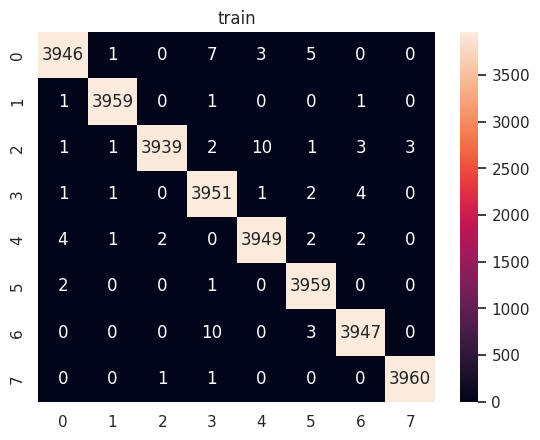

In [76]:
ax = sns.heatmap(confusion_matrix(*outputs["train"]), annot=True, fmt="d")
ax.set_title("train")

<Axes: xlabel='Predicted', ylabel='True'>

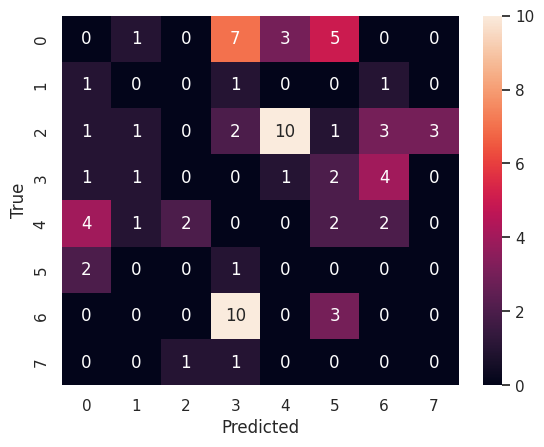

In [77]:
confusion_diag_zero(*outputs["train"])

Text(0.5, 1.0, 'val')

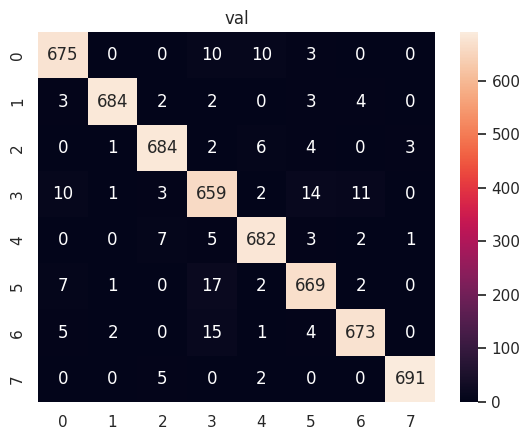

In [78]:
ax = sns.heatmap(confusion_matrix(*outputs["val"]), annot=True, fmt="d")
ax.set_title("val")

<Axes: xlabel='Predicted', ylabel='True'>

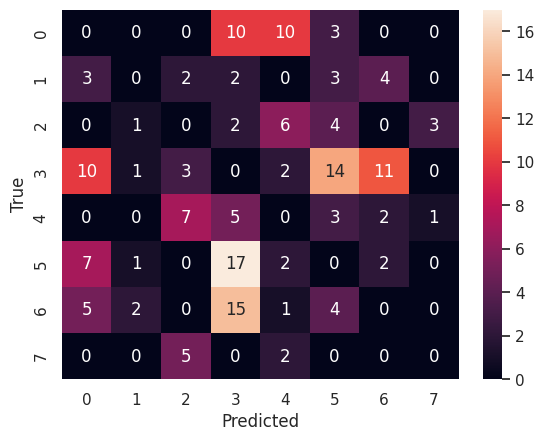

In [79]:
confusion_diag_zero(*outputs["val"])